In [19]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

In [20]:
# Load the data and libraries
import pandas as pd
import numpy as np

bear = pd.read_csv('https://raw.githubusercontent.com/jbennett979/Data_Privacy_FP/refs/heads/main/north_america_bear_killings.csv')

In [21]:
#removing space from the column name age\n",
bear.columns = [c.lstrip() for c in bear]
# capitalizing columns name for age and gende
bear= bear.rename(columns={'age': 'Age'})
bear= bear.rename(columns={'gender': 'Gender'})

In [22]:
print(bear.columns)
    # converting the age column who was a string to integers
bear['Age'] = pd.to_numeric(bear['Age'], errors = 'coerce')

Index(['Name', 'Age', 'Gender', 'Date', 'Month', 'Year', 'Type', 'Location',
       'Description', 'Type of bear', 'Hunter', 'Grizzly', 'Hikers',
       'Only one killed'],
      dtype='object')


In [23]:
#
def age_sum (epsilon):
   b = 75
   clipped_sum = bear['Age'].clip(upper=b).sum()

   return (laplace_mech(clipped_sum, sensitivity=b, epsilon=epsilon))

age_sum(1.0)

np.float64(5910.7207035349165)

In [24]:
def dp_avg_age(epsilon):

    noisy_sum = age_sum(epsilon/2)

    noisy_count = laplace_mech(len(bear), sensitivity=1, epsilon=epsilon/2)

    mean = noisy_sum/noisy_count

    return mean

dp_avg_age(1.0)

np.float64(37.9174776009418)

In [25]:
 # starting with choosing a clip param using clip b param for age

def age_pick_b(epsilon):
   bs =  range(1,200,10)
   last_result = 0
   epsilon_i = epsilon / len(bs)

   for b in bs:
    #try b
    clipped_sum = bear['Age'].clip(upper=b).sum()
    result= (laplace_mech(clipped_sum, sensitivity=b, epsilon=epsilon_i))

    if result < last_result:
        return b
    else:
        last_result = result
    #raise Exception('No good clipping parameter found')

age_pick_b(1.0)

41

In [26]:
# differential private
def monthly_counts (epsilon):

   count= bear['Month'].value_counts()

   return (laplace_mech(count, sensitivity=1, epsilon=epsilon))

monthly_counts(1.0)

Month
8     29.687586
7     28.687586
10    25.687586
9     25.687586
6     21.687586
5     19.687586
11    13.687586
4      5.687586
1      4.687586
12     3.687586
2      2.687586
3      2.687586
Name: count, dtype: float64

In [27]:
# differential private
def year_counts (epsilon):

   count= bear['Year'].value_counts()

   return (laplace_mech(count, sensitivity=1, epsilon=epsilon))

year_counts(1.0)

Year
1980    8.172905
2005    8.172905
2018    7.172905
1983    6.172905
1992    6.172905
          ...   
1930    2.172905
1922    2.172905
1916    2.172905
1908    2.172905
1906    2.172905
Name: count, Length: 74, dtype: float64

In [28]:
# range queries
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)]) # this runs the range query

random_lower_bounds = [random.randint(1, 70) for _ in range(100)]
random_workload = [(lb, random.randint(lb, 100)) for lb in random_lower_bounds]
real_answers = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]


In [29]:
def workload_laplace_vec(workload, epsilon):
    l1_sens = len(workload)
    workload_answer = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]
    laplace_vec=  laplace_mech_vec(workload_answer, l1_sens, epsilon=epsilon)
    return laplace_vec
print('First 4 answers:', workload_laplace_vec(random_workload, 1.0)[:4])

First 4 answers: [49.86603620827201, 18.14511818268906, -7.744681409830164, 96.63996644852526]


In [30]:
errors_1 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(random_workload, 1.0))]
print('Average absolute error:', np.mean(errors_1))
assert np.mean(errors_1) > 20
assert np.mean(errors_1) < 150

Average absolute error: 127.31880749682466


In [31]:
# Renyi DP
def workload_gaussian_vec_RDP(workload, alpha, epsilon_bar):

    def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
        sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
        return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

    sensitivity = np.sqrt(len(workload))
    answers = gaussian_mech_RDP_vec([range_query(bear, 'Age', lb, ub) for (lb, ub) in workload],
                                    sensitivity, alpha, epsilon_bar)
    return answers

In [32]:
#conversion
def convert_RDP_ED(alpha, epsilon_bar, delta):
   new_epsilon = epsilon_bar + np.log(1/delta) / (alpha-1)
   return new_epsilon

convert_RDP_ED(5, 0.1, 1e-5)

np.float64(2.9782313662425572)

In [33]:
errors_2 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec_RDP(random_workload, 1.0, 1e-5))]
print('Average absolute error:', np.mean(errors_2))
assert np.mean(errors_2) > 10
assert np.mean(errors_2) < 100

Average absolute error: 1757.5631541759224


AssertionError: 

In [36]:
# Gaussian mech
def workload_gaussian_vec(workload, epsilon, delta):
    sensitivity = np.sqrt(len(workload))
    workload_answer = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]
    gaussian_vec= gaussian_mech_vec(workload_answer, sensitivity=sensitivity, epsilon=epsilon , delta=delta)
    return gaussian_vec

In [37]:
errors_3 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(random_workload, 2.9782313662425572, 0.1))]
print('Average absolute error:', np.mean(errors_3))
assert np.mean(errors_3) > 10
assert np.mean(errors_3) < 100

# for renyy do the conversion , covert epsilon t
# set my epsilon bar = 1.0
# alpha to 5
# 2 set esplon to the conversion
# run both mechanisms
#rdp first and gaussian use the result of mech conversipn to do the gaussian.
# what did we learn about the data
# run on all of the columns on the loop instead of age by itself
#how epsilon on x axis , percent error on y , maybe having to show how it represents


Average absolute error: 6.121475233956982


AssertionError: 

[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0]
[np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905), np.float64(97.70114259777905)]


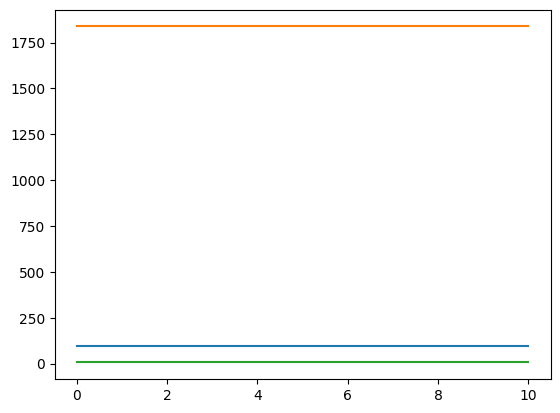

In [25]:
def graphing():
    epsilon_list = [0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0 ]
    errors_lp = []
    errors_rdp = []
    errors_g = []
    for epsilon in epsilon_list:
        #print('Epsilon:', epsilon)
        errors_lp.append(np.mean(errors_1))
        errors_rdp.append(np.mean(errors_2))
        errors_g.append(np.mean(errors_3))

    plt.plot(epsilon_list, errors_lp, label='laplace')
    plt.plot(epsilon_list, errors_rdp, label='RDP')
    plt.plot(epsilon_list, errors_g, label='gaussian_RDP')
    plt.show()

# TODO: work on the graph for each mechanisms over different epsilon
graphing()